In [367]:
%matplotlib inline

import os
import sys
import random
import imp


import numpy as np
import pandas as pd
import xarray as xr


import climatools.aerosol.aerosol as climaaerosol
import climatools.io.cesm as climaio
import climatools.aerosol.aerosol_constants as aeroconst
import climatools.rrtmg.column_model as rrtmg_column
import climatools.units as climaunits


imp.reload(climaaerosol)
imp.reload(climaio)
imp.reload(aeroconst)
imp.reload(rrtmg_column)
imp.reload(climaunits)

<module 'climatools.units' from '/nuwa_cluster/home/jackyu/climatools/climatools/units.py'>

# General workflow 

### Global dataset

In [2]:
## where are the CAM history files
dir_camhist = '/scratch/lupin/cesm1/archive/f19_g16.B1850.std/atm/hist'

In [3]:
## Prep o3 concentration data

ds_o3 = climaaerosol.OZONE_DATASET
da_o3 = ds_o3['O3']

# interpolate o3 concentration along lev
levinterpfunc_da_o3 = climaaerosol.get_interpfunc(da_o3, dim='lev')

# evaluate o3 concentration at the 30 levs of CAM history
filepath_camhist = os.path.join(dir_camhist,
                                random.choice(os.listdir(dir_camhist)))
ds_camhist = xr.open_dataset(filepath_camhist, decode_cf=False)

da_o3_levinterp = levinterpfunc_da_o3(coords=ds_camhist.coords['lev'])


# interpolate o3 concentration along time
timeinterpfunc_o3 = climaaerosol.get_interpfunc(da_o3_levinterp,
                                                dim='time')

In [119]:
# use this cell if IATM = 0 (i.e skipping RRTATM) 

aerosol = True

print("load a CAM history file from some previous global run")
ds = climaio.load_camhistory(readfrom='f19_g16.B1850.std.cam2.h0.0001-06.nc')

print("convert hybrid levels/layers to pressure levels/layers")
ds = climaunits.hybrid2mbar(ds)

print("get pressure difference for layer mass")
ds = climaaerosol.get_pressure_difference(ds)

print("interpolate layer values to levels for: T")
ds = climaaerosol.interp_layers2levels(ds, vars=['T'])

print("get ozone concentration for the time in this CAM history file")
ds = climaaerosol.get_o3_concentration(ds, interpfunc=timeinterpfunc_o3)

print("get o2 concentration")
ds = climaaerosol.get_o2_concentration(ds)

if aerosol:
    print('You asked for aerosol. You got it.')
    # gather aerosol species mmr into a new variable in the dataset    
    ds = climaaerosol.aerosol_species_mmr(ds)

    # aerosol water uptake. computes qaerwat, dgncur_awet, wetdens. add to ds
    ds = climaaerosol.wateruptake(ds)
    
    # compute and add to ds modal aerosol optical properties 
    ds = climaaerosol.modal_aero_sw(ds)

stackdims = ('time', 'lat', 'lon')

#cols = ds['RELHUM'].stack(cols=stackdims).coords['cols']

#print()

#for time, lat, lon in cols.values[:1]:
#    print("Working on column at time {}, lat {}, lon {}".format(time, lat, lon))
#    print("write input tapes for RRTMG column model")
#    rrtmg_column.write_input_rrtm(ds_col, aerosol=aerosol, iatm=0)
#    rrtmg_column.write_sw_inputfiles(ds,
#                                     time=time, lat=lat, lon=lon,
#                                     aerosol=aerosol)

#    print("execute RRTMG")
#    assert os.system('./rrtmg.exe') == 0

#    print("this dataset contains things like flux down, up and heating rates")
#    ds_rrtmg_col = climarrtmg.load_OUTPUT_RRTM(readfrom='OUTPUT_RRTM', 
#                                               signed_fluxes=True)
#    ds_rrtmg.loc[dict(time=time, lat=lat, lon=lon)] = ds_rrtmg_col

#    print("write RRTMG output to netCDF file")
#    ds_rrtmg.to_netcdf('RRTMG_f19_g16.B1850.std.cam2.h0.0001-06.nc')
    
#    print()




load a CAM history file from some previous global run
convert hybrid levels/layers to pressure levels/layers
get pressure difference for layer mass
interpolate layer values to levels for: T
get ozone concentration for the time in this CAM history file
get o2 concentration
You asked for aerosol. You got it.


### Column dataset for INPUT_RRTM (gas molecules)

In [5]:
# constants

AMD = 28.9660
AMW = 18.0160
AVOGAD = 6.02214199e23

GRAV = 9.8066

In [6]:
def column_density_dryair(h2o=None, pdp=None):
    '''
    Parameters
    ----------
    h2o: H2o volume mixing ratio
    pdp: layer pressure difference [hPa, mb]
    coldry: dry air column density [molecules/cm**2]
    '''
    dims = ('time', 'lat', 'lon', '')
    amm = (1 - h2o) * AMD + h2o * AMW
    coldry = pdp * 1e3 * AVOGAD / (1e2 * GRAV * amm * (1 + h2o))
    return coldry    

In [264]:
# select a single (time, lat, lon)
ds_col = ds.sel(time=0, lat=60, lon=350, method='nearest')

In [265]:
# import only the needed data variables to begin with
ds_col = ds_col[['ilev', 'lev',
                 'level_pressure', 'layer_pressure', 'dpressure',
                 'iT', 'T',
                 'Q', 'co2vmr', 'O3', 'n2ovmr', 'ch4vmr', 'o2mmr']]

In [266]:
ds_col = ds_col.rename({'T': 'layer_temperature',
                        'iT': 'level_temperature'})

In [267]:
# H2O: Convert [kg/kg] to [l/l]
layer_vmr_h2o = climaunits\
                .mixingratio_mass2volume(substance_name='H2O', 
                                          mass_mix=ds_col['Q'])
ds_col['layer_vmr_h2o'] = (('lev',), 
                            layer_vmr_h2o,
                            {'units': 'vmr',
                             'long_name': 'h2o mixing ratio by volume'})

In [268]:
# CO2: broadcast co2vmr to all layers and name it layer_vmr_co2

layer_vmr_co2 = ds_col['co2vmr'].values * np.ones((ds_col.dims['lev']))
ds_col['layer_vmr_co2'] = (('lev', ),
                           layer_vmr_co2,
                            {'units': 'l/l',
                             'long_name': 'co2 mixing ratio by volume'})

In [269]:
# O3: rename O3 to layer_vmr_o3

layer_vmr_o3 = ds_col['O3'].values * np.ones((ds_col.dims['lev']))
ds_col['layer_vmr_o3'] = (('lev', ),
                          layer_vmr_o3,
                          {'units': 'l/l',
                           'long_name': 'o3 mixing ratio by volume'})

In [270]:
# N2O: rename n2ovmr to layer_vmr_n2o

layer_vmr_n2o = ds_col['n2ovmr'].values * np.ones((ds_col.dims['lev']))
ds_col['layer_vmr_n2o'] = (('lev', ),
                           layer_vmr_n2o,
                           {'units': 'l/l',
                            'long_name': 'n2o mixing ratio by volume'})

In [271]:
# CO: set to zero
ds_col['layer_vmr_co'] = (('lev',),
                           np.zeros((ds_col.dims['lev'])),
                           {'units': 'l/l', 
                            'long_name': 'co mixing ratio by volume'})

In [272]:
# CH4: convert [l/l] to [ppmv]
layer_vmr_ch4 = ds_col['ch4vmr'].values * np.ones((ds_col.dims['lev']))
ds_col['layer_vmr_ch4'] = (('lev', ),
                           layer_vmr_ch4,
                           {'units': 'l/l',
                            'long_name': 'ch4 mixing ratio by volume'})

In [273]:
# O2: convert [g/g] to [vmr] and broadcast to all layers
layer_vmr_o2 = climaunits.mixingratio_mass2volume(substance_name='O2',
                                                  mass_mix=ds_col['o2mmr'])
layer_vmr_o2 = layer_vmr_o2.values * np.ones((ds_col.dims['lev'],))
ds_col['layer_vmr_o2'] = (('lev',),
                          layer_vmr_o2,
                           {'units': 'l/l',
                            'long_name': 'o2 mixing ratio by volumne'})

In [274]:
# reset layer and level index to integer values starting from 1
ds_col.coords['lev'] = range(1, ds.dims['lev'] + 1)
ds_col.coords['ilev'] = range(1, ds.dims['ilev'] + 1)

In [275]:
# reindex layer and level with an additional index number
ds_col = ds_col.reindex(lev=range(ds.dims['lev'] + 1))
ds_col = ds_col.reindex(ilev=range(ds.dims['ilev'] + 1))

In [276]:
# assign top layer and level pressures
ds_col['layer_pressure'][dict(lev=0)] = (.5 * ds_col['level_pressure']
                                         .isel(ilev=1))
ds_col['level_pressure'][dict(ilev=0)] = 1e-4

In [277]:
# assign top layer and level temperatures
ds_col['layer_temperature'][dict(lev=0)] = (ds_col['layer_temperature']
                                            [dict(lev=1)])
ds_col['level_temperature'][dict(ilev=1)] = (.5 * 
                                             sum(ds_col['layer_temperature']
                                                 [dict(lev=[0,1])]))
ds_col['level_temperature'][dict(ilev=0)] = (ds_col['level_temperature']
                                             [dict(ilev=1)])

In [278]:
# assign top layer molecule densities
names_molecules = ['h2o', 'co2', 'o3', 'n2o', 'co', 'ch4', 'o2']
for molecule in names_molecules:
    name_var = 'layer_vmr_' + molecule
    ds_col[name_var][dict(lev=0)] = ds_col[name_var][dict(lev=1)]

In [279]:
# compute layer pressure difference
ds_col = climaaerosol.get_pressure_difference(ds_col)

In [280]:
ds_col = ds_col.drop(['Q', 'co2vmr', 'O3', 'n2ovmr', 'ch4vmr', 'o2mmr'])

In [281]:
# calculate column density of dry air
coldens_dryair = column_density_dryair(h2o=ds_col['layer_vmr_h2o'],
                                       pdp=ds_col['dpressure'])
ds_col['layer_coldens_dryair'] = (('lev',), coldens_dryair)

h2o_lev1 = ds_col['layer_vmr_h2o'][dict(lev=1)]
amm = (1 - h2o_lev1) * AMD + h2o_lev1 * AMW
ds_col['layer_coldens_dryair'][dict(lev=0)] = (ds_col['level_pressure'][dict(ilev=1)]
                                               * 1e3 * AVOGAD / 
                                               (1e2 * GRAV * amm * (1 + h2o_lev1)))

In [282]:
# convert molecule densities from vmr to column density
names_molecules = ['h2o', 'co2', 'o3', 'n2o', 'co', 'ch4', 'o2']
for name in names_molecules:
    ds_col['layer_coldens_' + name] = (ds_col['layer_vmr_' + name]
                                       * ds_col['layer_coldens_dryair'])

In [283]:
# drop data variables for molecule densities in vmr
ds_col = ds_col.drop([name for name in ds.data_vars if '_vmr_' in name])

In [284]:
ds_col['juldat'] = ((), 0., {'long_name': 'Julian day associated with calculation',
                             'units': 'days'})
ds_col['sza'] = ((), 60, {'long_name': 'solar zenith angle in degrees',
                          'units': 'degrees'})

In [285]:
rrtmg_column.write_input_rrtm(ds=ds_col, aerosol=True, iatm=0)

### Column dataset for IN_AER_RRTM

In [389]:
# select a single (time, lat, lon)
ds_col = ds.sel(time=0, lat=60, lon=350, method='nearest')

In [390]:
# keep only the needed aerosol-related data variables
vs_aerosol = ['tauxar', 'wa', 'ga']
ds_col = ds_col[vs_aerosol]

In [391]:
# replace with some fake values that might be more sensible in ragne
ds_col['tauxar'] = (ds_col['tauxar'].dims,
                    .02 * np.ones(ds_col['tauxar'].shape),
                    ds_col['tauxar'].attrs)

ds_col['wa'] = (ds_col['wa'].dims,
                np.zeros(ds_col['wa'].shape), 
                ds_col['wa'].attrs)

ds_col['ga'] = (ds_col['ga'].dims,
                np.zeros(ds_col['ga'].shape), 
                ds_col['ga'].attrs)

In [392]:
# reset layerindex to integer values starting from 1
ds_col.coords['lev'] = range(1, ds_col.dims['lev'] + 1)

In [393]:
# reindex layer with an additional index number
ds_col = ds_col.reindex(lev=range(ds_col.dims['lev'] + 1))

In [394]:
ds_col['tauxar'][dict(lev=0)] = 0.
ds_col['wa'][dict(lev=0)] = 0.
ds_col['ga'][dict(lev=0)] = 0.

In [395]:
rrtmg_column.write_in_aer_rrtm(ds=ds_col)

### Run RRTMG

In [398]:
!rm IN_AER_RRTM
!ln -s IN_AER_RRTM_temp IN_AER_RRTM

In [399]:
!./rrtmg_cont_layeraerosol.exe

 iaer =                       10
 iatm =                        0
 iscat =                        1
 istrm =                        0
 iout =                       98
 imca =            0
 icld =                        0
 idelm =                        0
 icos =                        0
 juldat =            0
 sza =    60.00000000000000     
 isolvar =                        0
 solvar =    0.000000000000000         0.000000000000000      
    0.000000000000000         0.000000000000000         0.000000000000000      
    0.000000000000000         0.000000000000000         0.000000000000000      
    0.000000000000000         0.000000000000000         0.000000000000000      
    0.000000000000000         0.000000000000000         0.000000000000000      
    0.000000000000000         0.000000000000000         0.000000000000000      
    0.000000000000000         0.000000000000000         0.000000000000000      
    0.000000000000000         0.000000000000000         0.000000000000000    

### Plot too see if results are reasonable

In [29]:
from IPython import display

import matplotlib.pyplot as plt

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz
import rtmtools.rrtmg.sw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse
import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse


imp.reload(aerutils)
imp.reload(aeranalyse)
imp.reload(viz)

imp.reload(rrtmgwrangle)
imp.reload(rrtmganalyse)
imp.reload(cliradwrangle)
imp.reload(cliradanalyse)

<module 'rtmtools.clirad.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/clirad/sw/analyse.py'>

In [375]:
pnl_rrtmg_noaero = rrtmgwrangle.\
OUTPUT_RRTM_to_pandasPanel(readfrom='OUTPUT_RRTM_iaer10_layers_taua_ssaa_asym_0_cont',
                           cooling_rate=False,
                           signed_fluxes=True)

In [396]:
pnl_rrtmg_aero = rrtmgwrangle.\
OUTPUT_RRTM_to_pandasPanel(readfrom='OUTPUT_RRTM',
                           cooling_rate=False, signed_fluxes=True)

In [387]:
name_molecule = r'$H_{2}O$'

def plot_total_heating_rates(infos_wavenumber = None, infos_spectralband = None):
    global name_molecule, xlim_linear
    atm_levels = [30, 15, 0]

    if infos_wavenumber:
        (names_wavenumber, colours_wavenumber, 
         linestyles_wavenumber, pnls_wavenumber) = map(list, zip(*infos_wavenumber))
    
        dfs_wavenumber = [aeranalyse.\
                          sum_OUTPUT_RADSUM_over_wbands(pnl, V1 = 1000, V2 = 25000) \
                          for pnl in pnls_wavenumber]
    else:
        (dfs_wavenumber, names_wavenumber, 
         colours_wavenumber, linestyles_wavenumber) = ([], [], [], [])
        
    if infos_spectralband:
        (names_spectralband, colours_spectralband, 
         linestyles_spectralband, pnls_spectralband) = map(list, zip(*infos_spectralband))
    
        dfs_spectralband = [cliradanalyse.\
                            sum_OUTPUT_CLIRAD_over_wbands(pnl, 
                                                          wbands = range(1, 11))
                            for pnl in pnls_spectralband]
    else:
        (dfs_spectralband, names_spectralband,
         colours_spectralband, linestyles_spectralband) = ([], [], [], [])

    dfs = dfs_wavenumber + dfs_spectralband
    names = names_wavenumber + names_spectralband
    colours = colours_wavenumber + colours_spectralband
    linestyles = linestyles_wavenumber + linestyles_spectralband    
    
    dfs_atm_levels = [df.loc[atm_levels, :] for df in dfs]
    
    viz.tabulate_difference(dfs = dfs_atm_levels, 
                            names = names,
                            title = 'Total heating rate. {}'.format(name_molecule))    
    
    max_cr = max([df['heating_rate'].max() for df in dfs])
    
    viz.plot_pres_vs_hrcr(dfs = dfs_wavenumber + dfs_spectralband,
                          names = names_wavenumber + names_spectralband,
                          linestyles = linestyles_wavenumber + linestyles_spectralband, 
                          colours = colours_wavenumber + colours_spectralband,
                          title = 'Total heating rate. {}'.format(name_molecule),
                          cooling_rate = False,
                          xlim_linear = None,
                          xlim_log = None)
    
    display.display(plt.gcf()); plt.close()


Total heating rate. $H_{2}O$

no aerosol
    pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
30     2.255        0             0      592.0282   592.0282  592.0282   
15   297.200        0             0      571.7140   571.7140  571.7140   
0   1007.500        0             0      467.7196   467.7196  467.7196   

    heating_rate  
30       2.69210  
15       0.54647  
0        1.24126  

aerosol
    pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
30     2.255        0             0      592.0282   592.0282  592.0282   
15   297.200        0             0      313.8198   313.8198  313.8198   
0   1007.500        0             0      140.9243   140.9243  140.9243   

    heating_rate  
30       2.69210  
15       2.72279  
0        3.62462  

no aerosol - aerosol
    pressure  flux_up  flux_difdown  flux_dirdown  flux_down  net_flux  \
30         0        0             0        0.0000     0.0000    0.0000   
15         0        0            

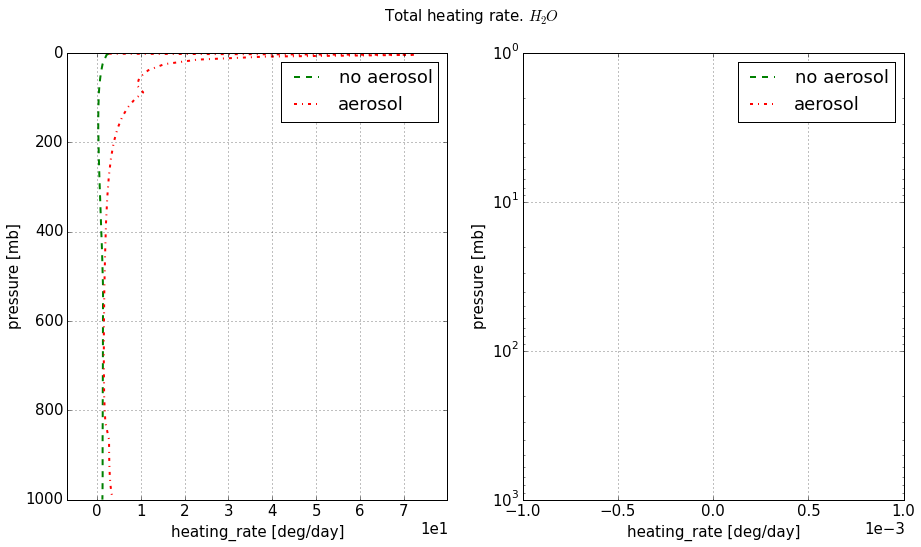

In [397]:
plot_total_heating_rates(infos_wavenumber=[('no aerosol', 'g', '--', pnl_rrtmg_noaero),
                                           ('aerosol', 'r', '-.', pnl_rrtmg_aero)])

In [33]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')